# Notes
We reproduce the Target approach in [1]. We compare our results with that in [1].

[1] Gordon V. Cormack and Maura R. Grossman. 2016. Engineering Quality and Reliability in Technology-Assisted Review. In Proceedings of the 39th International ACM SIGIR Conference on Research and Development in Information Retrieval(Pisa, Italy) (SIGIR ’16). ACM, New York, NY, USA, 75–84.



In [17]:
import os
import re
import glob
import subprocess
import pandas as pd
from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [18]:
project_dir = os.path.abspath('../..')
tar_master_dir = os.path.join(project_dir, 'tar-master')
data_dir = os.path.join(project_dir, 'baseline_reproduction', 'target', 'data')
ret_dir = os.path.join(project_dir, 'baseline_reproduction', 'target', 'ret')

athome123_topics = [
"athome100",
"athome101",
"athome102",
"athome103",
"athome104",
"athome105",
"athome106",
"athome107",
"athome108",
"athome109",
"athome2052",
"athome2108",
"athome2129",
"athome2130",
"athome2134",
"athome2158",
"athome2225",
"athome2322",
"athome2333",
"athome2461",
"athome3089",
"athome3133",
"athome3226",
"athome3290",
"athome3357",
"athome3378",
"athome3423",
"athome3431",
"athome3481",
"athome3484",
]




# Results in paper [1]


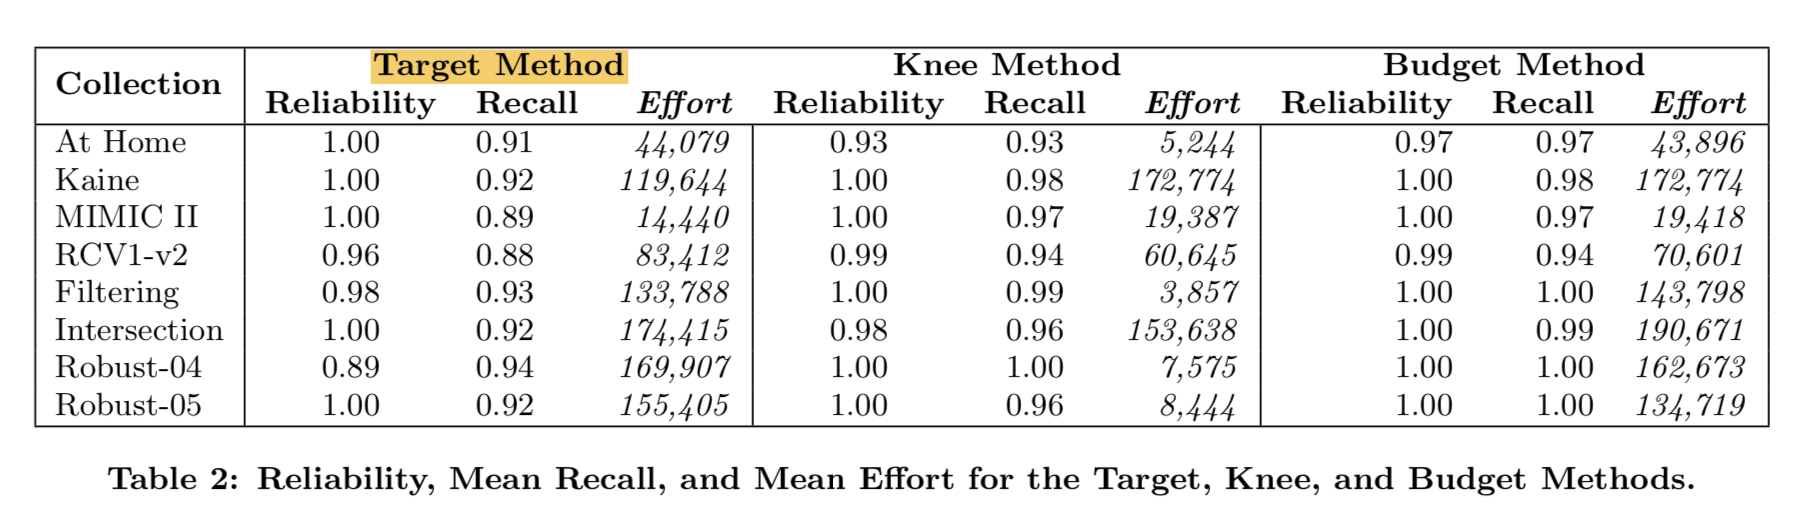

In [9]:
Image(filename='./images/table2.png', width=500)

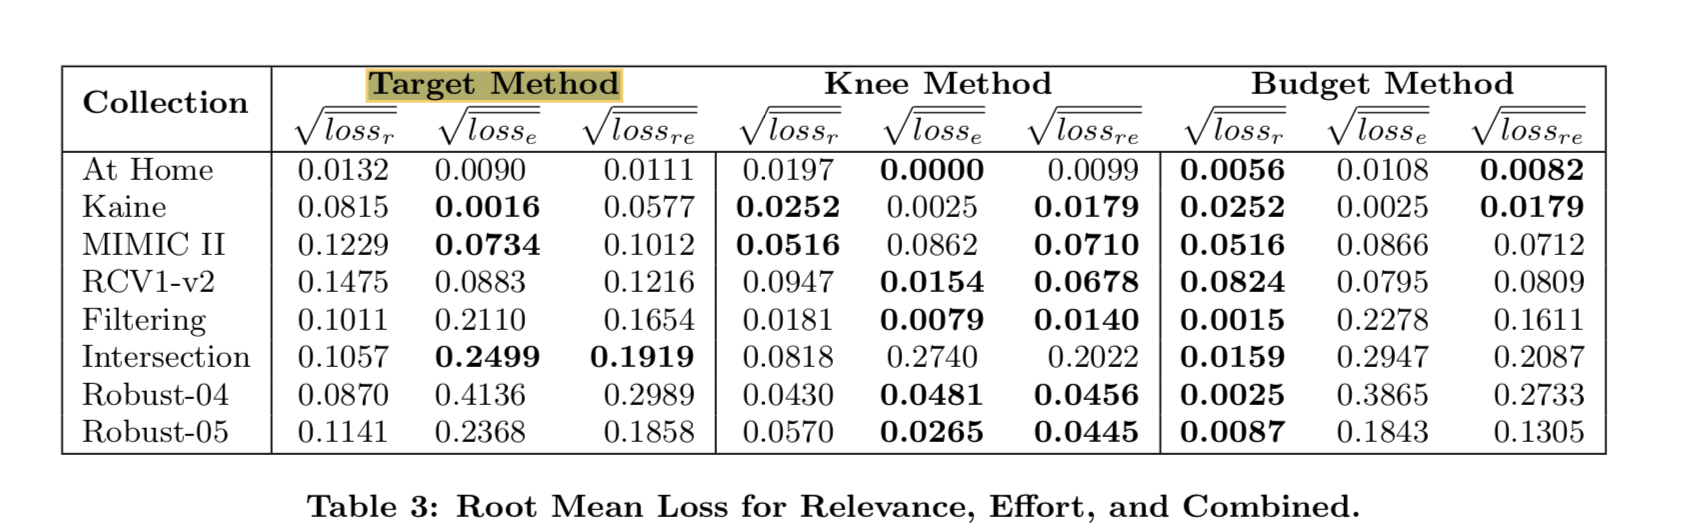

In [10]:
Image(filename='./images/table3.png', width=500)

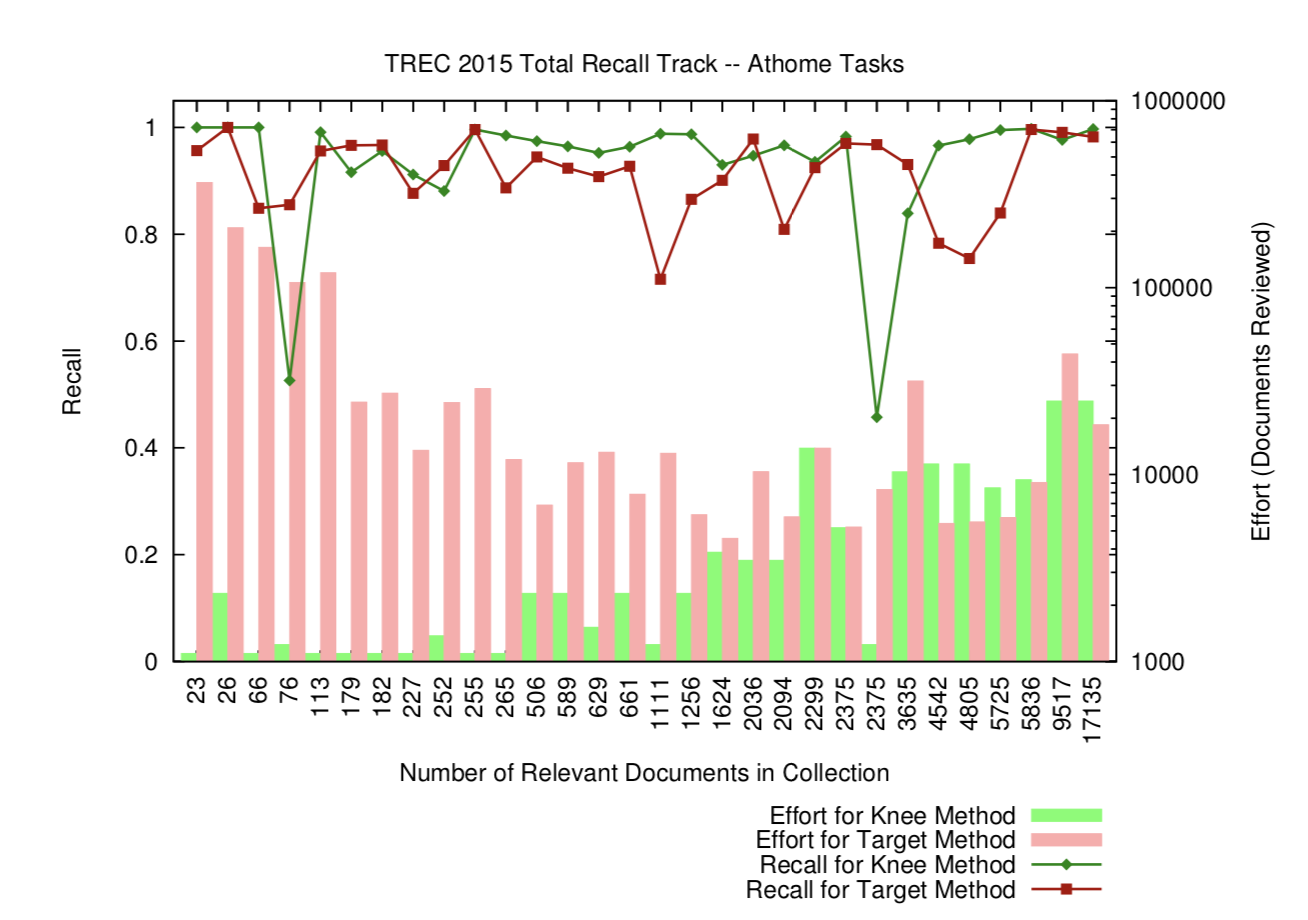

In [11]:
Image(filename='./images/figure.png', width=500)

# Reproduce Target

- We use the same dataset (`athome1` `athome2` `athome3`) as [1].
    
- The recommended value reported in [1] is 10. Based on this, we also conducted a hyper-parameter sweeping: we alternate `target_rel_num` between 5, 10, and 15. The best hyperparameter configuration (`target_rel_num = 5`) leads to a recall of 0.93 and number of reviewed documents of 49,151, while the reported metrics in [1] are 0.91 and 44,079.

In [19]:
def check_file(filepath):
    if not os.path.exists(filepath):
        print('not existing file {}'.format(filepath))
    if os.path.getsize(filepath) == 0:
        print('zero byte file {}'.format(filepath))


def tar_eval(model_name, topic_id):
    
    # run file
    runfile = os.path.join(ret_dir, model_name, '1', 'train', topic_id + '.run')
    check_file(runfile)
    
    # qrel file
    qrelfile = os.path.join(data_dir, 'qrels', topic_id)
    check_file(qrelfile)
    
    # tar eval script
    script = os.path.join(tar_master_dir, 'scripts/tar_eval.py')
    
    # result
    ret = subprocess.check_output(['python', script, qrelfile, runfile])
    ret = subprocess.check_output([' tail -27 '], shell=True, input=ret)
    ret = ret.decode(encoding='utf-8')
   
    # dataframe
    dct = {}
    for line in ret.split('\n'):
      if line != '':
            tid, key, val = line.split()
            if tid == 'ALL':
                dct[key] = [float(val)]
    
    df = pd.DataFrame(dct)
    df['model_name'] = [model_name]
    df['topic_id'] = [topic_id]
    df['recall'] = float(df['rels_found']) / float(df['num_rels'])
    df['cost'] = float(df['num_shown']) / float(df['num_docs'])
    return df


def plot_recall_cost(df):
    df = df.sort_values(by="num_rels")
    df = df.reset_index(drop=True)
 
    fig, axarr = plt.subplots(3, 1, figsize=(8, 15)) 
    ax = sns.barplot(x='topic_id', y='num_rels', data=df, ax=axarr[0])

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
    ax = sns.barplot(x='topic_id', y='recall', data=df, ax=axarr[1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
    ax = sns.barplot(x='topic_id', y='num_shown', data=df, ax=axarr[2])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
    return


In [20]:
dfs = []
for topic_id in athome123_topics:
    for trn in [5, 10, 15]:
        _df = tar_eval(model_name='target_only_tar_sp0.5_sr1.0_md3_c1.0_trn{}'.format(trn), topic_id=topic_id)
        _df['trn'] = trn
        _df['mindf'] = 3
        dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)

## `target_rel_num = 5`

recall           0.936646
num_shown    49151.800000
dtype: float64


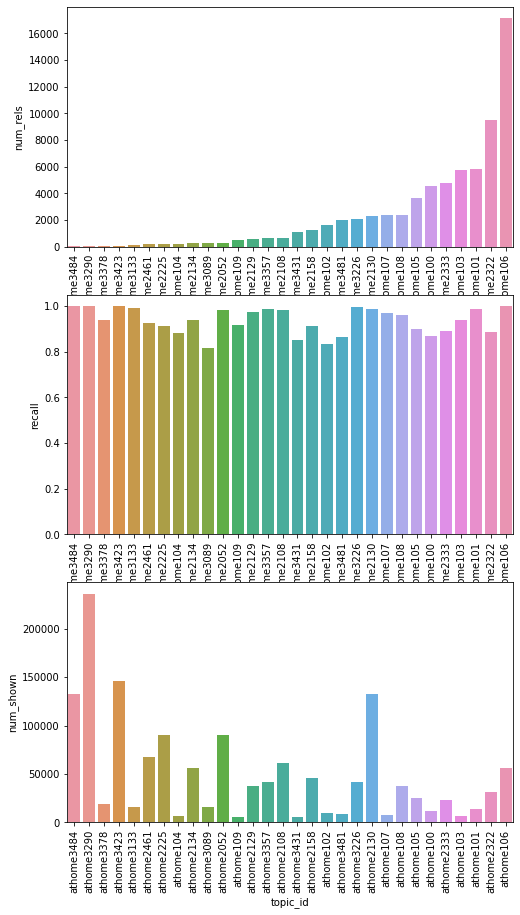

In [26]:
dff = df[df['trn'] == 5]
print(dff[['recall', 'num_shown']].mean())
plot_recall_cost(dff)

## `target_rel_num = 10`

recall           0.915997
num_shown    39856.100000
dtype: float64


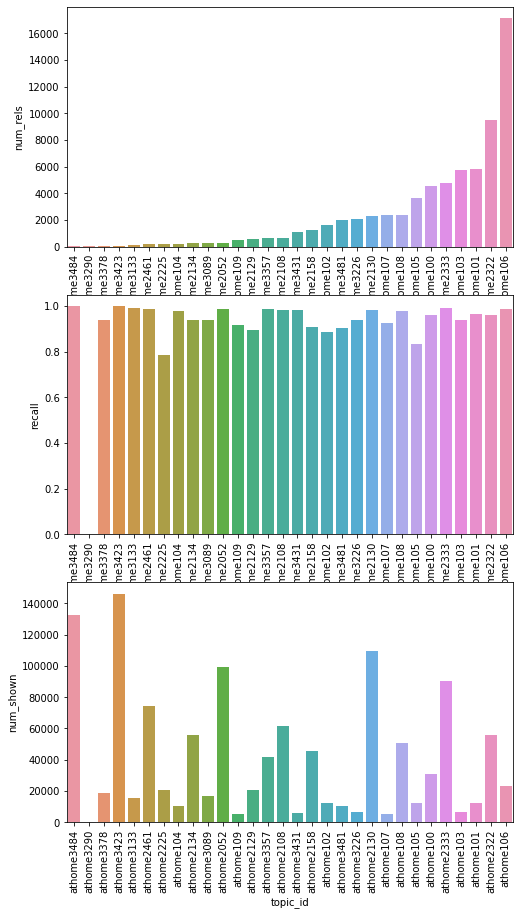

In [28]:
dff = df[df['trn'] == 10]
print(dff[['recall', 'num_shown']].mean())
plot_recall_cost(dff)

## `target_rel_num = 15`

recall           0.916847
num_shown    52581.900000
dtype: float64


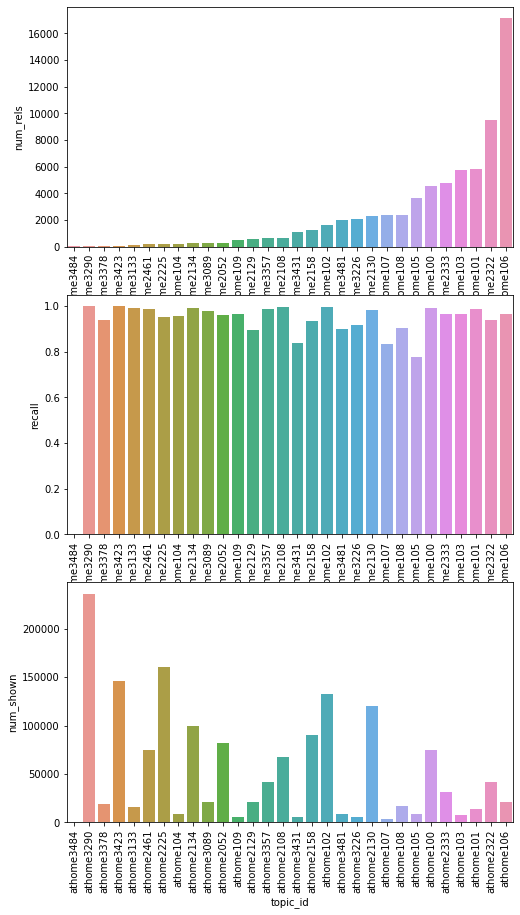

In [30]:
dff = df[df['trn'] == 15]
print(dff[['recall', 'num_shown']].mean())
plot_recall_cost(dff)